# CAPSTONE
Kehinde Ajayi

Initial modeling

In [1]:
## check if notebook is running on Colab--if so, run appropriate installs and mount Google Drive
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

if 'google.colab' in str(get_ipython()):
  # install RDKit and DeepChem
  !pip install rdkit-pypi scikit-learn --pre deepchem tensorflow-addons
  # mount Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

In [2]:
# clone bert-loves-chemistry repo
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

fatal: destination path 'bert-loves-chemistry' already exists and is not an empty directory.


In [3]:
# import chemberta language model
%cd ./bert-loves-chemistry/
!pwd

/home/kajayi/Capstone/ka_capstone/notebooks/bert-loves-chemistry
/home/kajayi/Capstone/ka_capstone/notebooks/bert-loves-chemistry


In [6]:
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
    sys.path += ['bertviz_repo']

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import datetime
import sys
import os

from tqdm.auto import tqdm

from rdkit import Chem

from rdkit.Chem import PandasTools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, f1_score, ConfusionMatrixDisplay, accuracy_score, make_scorer, log_loss, classification_report, roc_auc_score, recall_score, RocCurveDisplay, matthews_corrcoef
from sklearn.pipeline import Pipeline

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import torch.nn as nn
import torch.nn.functional as F

import tensorboard

from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer

import deepchem as dc
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
from deepchem.models import GraphConvModel, MultitaskClassifier

from hyperopt import hp, fmin, tpe, Trials

from lime import lime_tabular

from apex import amp

from typing import List

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# from bertviz import head_view



# from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

In [3]:
tf.config.list_physical_devices('GPU')

2022-05-18 13:01:47.468886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-05-18 13:01:47.474295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 13:01:47.474897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# load Byte-Pair Encoding tokenizer and model, and setup a Huggingface pipeline for masked tokeni prediction.
model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

In [4]:
!pwd

/home/kajayi/Capstone/ka_capstone/notebooks


f using a tokenizer which splits SMILES sequences into syntatically relevant chemical tokens performs

In [12]:
current_dir = os.path.dirname(os.path.realpath(__file__))

NameError: name '__file__' is not defined

In [13]:
dir(os.path.realpath)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [14]:
vocab_path = os.path.join(current_dir, 'tests/data', 'vocab.txt')
tokenizer = SmilesTokenizer(vocab_path)
print(tokenizer.encode("CC(=O)OC1=CC=CC=C1C(=O)O"))

NameError: name 'current_dir' is not defined

In [15]:

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

NameError: name 'model' is not defined

## Functions and settings

In [5]:
# workaround for bug where molecular structure does not print with dataframe
# https://github.com/rdkit/rdkit/issues/2673
def show(df):
    return HTML(df.to_html(notebook=True))


In [6]:
tqdm.pandas()

In [7]:
# check if notebook is running on Colab and set path for data file 

def get_home_path():
  if 'google.colab' in str(get_ipython()):
    path = '/content/drive/MyDrive/GA/Capstone/ka_capstone'
  else:
    path = '..'
  
  return path


In [8]:
# view all columns in dataframe
pd.set_option('display.max.columns', None)

## Read data

In [20]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt

--2022-05-18 05:06:04--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.192.58
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.192.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3524 (3.4K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>]   3.44K  --.-KB/s    in 0s      

2022-05-18 05:06:04 (27.5 MB/s) - ‘vocab.txt’ saved [3524/3524]



In [21]:
# # read hERG data into dataframe 
# herg_df = PandasTools.LoadSDF(f'{get_home_path()}/data/interim/herg-data-with-structures.sdf', molColName='Mol', smilesName='SMILES', includeFingerprints=True, idName='Pubchem_SID')


In [9]:
# read hERG data without structure fingerprint into separate dataframe 
df = pd.read_csv(f'{get_home_path()}/data/interim/herg_data.csv')



In [10]:
df.head()

,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations,adjacency_matrix,label
0,22416348,Cc1occc1C(=O)NCc1ccco1,20.17528,30.99165,0,205.213,2.11102,55.38,1,3,4,2,2,3,0,0,22,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 0 1 0 0 ...,inactive
1,26665387,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,10.22630,13.05888,0,366.464,2.15220,51.24,0,7,8,3,1,4,0,0,43,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,inactive
2,862531,C[C@H](NC(=O)Nc1cccc(C(F)(F)F)c1)C(=O)O,2.04420,0.06288,0,276.214,2.30000,78.43,3,2,8,1,1,3,1,0,39,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 ...,inactive
3,26732361,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,21.80250,17.87858,0,466.534,3.25700,81.45,0,7,8,4,3,7,1,0,56,0,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...,inactive
4,49735227,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,8.33980,19.03128,0,550.700,3.10920,100.21,2,6,9,6,1,9,5,0,68,1,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...,inactive


In [24]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"

masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
  print(smi)

{'score': 0.9755934476852417, 'token': 33, 'token_str': '=', 'sequence': 'C1=CC=CC=C1'}
{'score': 0.02092384733259678, 'token': 7, 'token_str': '#', 'sequence': 'C1=CC=CC#C1'}
{'score': 0.0007658943650312722, 'token': 21, 'token_str': '1', 'sequence': 'C1=CC=CC1C1'}
{'score': 0.00041297581628896296, 'token': 22, 'token_str': '2', 'sequence': 'C1=CC=CC2C1'}
{'score': 0.0002531911013647914, 'token': 352, 'token_str': '=[', 'sequence': 'C1=CC=CC=[C1'}


In [15]:
df.SMILES

0                                    Cc1occc1C(=O)NCc1ccco1
1               COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1
2                   C[C@H](NC(=O)Nc1cccc(C(F)(F)F)c1)C(=O)O
3         COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...
4         COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...
                                ...                        
306860      CC(=O)CSc1nnc(CN2C(=O)CSc3ccc(C(F)(F)F)cc32)n1C
306861       O=C(COc1ccc(Cl)cc1)Nc1nnc(-c2ccc3c(c2)CCCC3)o1
306862             COc1ccc(C(=O)N2CCCC(CO)(Cc3ccccc3C)C2)o1
306863    CCOC(=O)[C@@H]1[C@H]2COc3ccc(Br)cc3[C@H]2N2C(=...
306864         Cc1cccc(Cn2cc(/C=C/[N+](=O)[O-])c3ccccc32)c1
Name: SMILES, Length: 306865, dtype: object

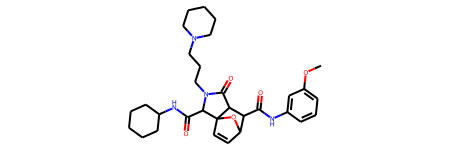

In [50]:
Chem.MolFromSmiles(df.SMILES[4])

In [10]:
# add image of molecule to dataframe
PandasTools.AddMoleculeColumnToFrame(df, 'SMILES', 'Mol')

In [8]:
df.info()

NameError: name 'df' is not defined

## Initial model without molecular fingerprint

### Create or load SMILES features


In [11]:
dir(SmilesTokenizer)

['SPECIAL_TOKENS_ATTRIBUTES',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tokens',
 '_batch_encode_plus',
 '_batch_prepare_for_model',
 '_convert_id_to_token',
 '_convert_token_to_id',
 '_convert_token_to_id_with_added_voc',
 '_create_or_get_repo',
 '_create_trie',
 '_decode',
 '_encode_plus',
 '_eventual_warn_about_too_long_sequence',
 '_from_pretrained',
 '_get_padding_truncation_strategies',
 '_get_repo_url_from_name',
 '_pad',
 '_push_to_hub',
 '_save_pretrained',
 '_set_processor_class',
 '_tokenize',
 'add_padding_tokens',
 'add_special_tokens',
 'add_special_tokens_ids_sequence_pair',
 'add_special_tokens_id

### Add SMILES tokens

In [12]:
smi_tokenizer = dc.feat.SmilesTokenizer('./bert-loves-chemistry/vocab.txt')

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [ ]:
hopefully = [np.array(smi_tokenizer.encode(smi)) for smi in df.SMILES] 

hopefully

In [83]:
df.SMILES[0]

'Cc1occc1C(=O)NCc1ccco1'

In [87]:
np.array(smi_tokenizer.encode(df.SMILES[0]))

array([12, 16, 15, 20, 44, 15, 15, 15, 20, 16, 17, 22, 19, 18, 23, 16, 15,
       20, 15, 15, 15, 44, 20, 13])

In [72]:
df['SMILES_tokens'] = [smi_tokenizer.encode(smi) for smi in df.SMILES] 

In [94]:
df['SMILES_tokens'] = df.SMILES.map(lambda smi: smi_tokenizer.encode(smi)) 

In [95]:
type(df.SMILES_tokens[0])

list

In [50]:
df.head()

,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations,adjacency_matrix,label,SMILES_tokens
0,22416348,Cc1occc1C(=O)NCc1ccco1,20.17528,30.99165,0,205.213,2.11102,55.38,1,3,4,2,2,3,0,0,22,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 0 1 0 0 ...,inactive,"[12, 16, 15, 20, 44, 15, 15, 15, 20, 16, 17, 2..."
1,26665387,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,10.22630,13.05888,0,366.464,2.15220,51.24,0,7,8,3,1,4,0,0,43,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,inactive,"[12, 16, 19, 15, 20, 15, 15, 15, 17, 39, 16, 2..."
2,862531,C[C@H](NC(=O)Nc1cccc(C(F)(F)F)c1)C(=O)O,2.04420,0.06288,0,276.214,2.30000,78.43,3,2,8,1,1,3,1,0,39,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 ...,inactive,"[12, 16, 33, 17, 23, 16, 17, 22, 19, 18, 23, 1..."
3,26732361,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,21.80250,17.87858,0,466.534,3.25700,81.45,0,7,8,4,3,7,1,0,56,0,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...,inactive,"[12, 16, 19, 15, 20, 15, 15, 17, 19, 16, 18, 1..."
4,49735227,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,8.33980,19.03128,0,550.700,3.10920,100.21,2,6,9,6,1,9,5,0,68,1,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...,inactive,"[12, 16, 19, 15, 20, 15, 15, 15, 15, 17, 23, 1..."


In [26]:
## load dataset if it exists and create it if it doesn't
try:
    # load existing dataset from disk
    dataset_smiles = dc.data.DiskDataset('../data/processed/smiles')
except ValueError:
    # create dataset
    dataset_file = f'{get_home_path()}/data/interim/herg_data.csv'
    tasks = ['herg_inhibitor']
    smi_tokenizer = dc.feat.SmilesTokenizer('./bert-loves-chemistry/vocab.txt')
    loader = dc.data.CSVLoader(tasks=tasks,
                               feature_field='SMILES',
                               featurizer=smi_tokenizer)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [27]:
dataset_smiles = loader.create_dataset(dataset_file, f'{get_home_path()}/data/processed/smiles', shard_size=8192)

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [21]:
## load dataset if it exists and create it if it doesn't
try:
    # load existing dataset from disk
    dataset_BERT = dc.data.DiskDataset('../data/processed/BERT')
except ValueError:
    # create dataset
    dataset_file = f'{get_home_path()}/data/interim/herg_data.csv'
    tasks = ['herg_inhibitor']
    bpe_tokenizer = dc.feat.RobertaTokenizerFast.from_pretrained('seyonec/PubChem10M_SMILES_BPE_450k')
    loader = dc.data.CSVLoader(tasks=tasks,
                               feature_field='SMILES',
                               featurizer=bpe_tokenizer)

In [22]:
dataset_BERT = loader.create_dataset(dataset_file, f'{get_home_path()}/data/processed/BERT', shard_size=8192)

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

### load fingerprint features

In [13]:
## load dataset if it exists and create it if it doesn't
try:
    # load existing dataset from disk
    fp_dataset = dc.data.DiskDataset('../data/processed/fingerprints')
except ValueError:
    # create dataset
    dataset_file = f'{get_home_path()}/data/interim/herg_data.csv'
    tasks = ['herg_inhibitor']
    featurizer = dc.feat.CircularFingerprint(size=1024)
    loader = dc.data.CSVLoader(tasks=tasks,
                               feature_field='SMILES',
                               featurizer=featurizer)
    fp_dataset = loader.create_dataset(dataset_file, f'{get_home_path()}/data/processed/fingerprints', shard_size=8192)

In [27]:
fp_dataset

<DiskDataset X.shape: (306865, 1024), y.shape: (306865, 1), w.shape: (306865, 1), task_names: ['herg_inhibitor']>

In [32]:
fp_dataset.X[4]

array([0., 0., 1., ..., 0., 0., 0.])

### load Graph features

In [35]:
## load dataset if it exists and create it if it doesn't
try:
    # load saved dataset
    gcn_dataset = dc.data.DiskDataset('../data/processed/ConvMolFeatures')
except ValueError:
    # create dataset
    dataset_file = f'{get_home_path()}/data/interim/herg_data.csv'
    tasks = ['herg_inhibitor']
    gcn_featurizer = dc.feat.ConvMolFeaturizer()
    loader = dc.data.CSVLoader(tasks=tasks,
                               feature_field='SMILES',
                               featurizer=gcn_featurizer)
    gcn_dataset = loader.create_dataset(dataset_file, f'{get_home_path()}/data/processed/ConvMolFeatures', shard_size=8192)

In [36]:
gcn_dataset

<DiskDataset X.shape: (306865,), y.shape: (306865, 1), w.shape: (306865, 1), task_names: ['herg_inhibitor']>

In [37]:
dir(gcn_dataset.X)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',

In [43]:
gcn4 = gcn_dataset.X[4]

In [44]:
dir(gcn4)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_deg_sort',
 'agglomerate_mols',
 'atom_features',
 'canon_adj_list',
 'deg_adj_lists',
 'deg_block_indices',
 'deg_id_list',
 'deg_list',
 'deg_slice',
 'deg_start',
 'degree_list',
 'get_adjacency_list',
 'get_atom_features',
 'get_atoms_with_deg',
 'get_deg_adjacency_lists',
 'get_deg_slice',
 'get_null_mol',
 'get_num_atoms',
 'get_num_atoms_with_deg',
 'max_deg',
 'membership',
 'min_deg',
 'n_atoms',
 'n_feat']

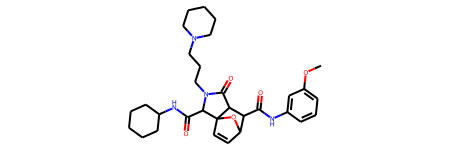

In [51]:
Chem.MolFromSmiles(df.SMILES[4])

In [54]:
gcn4.get_atom_features()

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [80]:
learning_rate19 = dc.models.optimizers.ExponentialDecay(0.001, 0.7, 1024)
save_dir19=f'{get_home_path()}/models/gcn_model_19'

model19 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[1024, 2048],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         learning_rate=learning_rate19,
                         model_dir=f'{get_home_path()}/models/gcn_model_19')
# validation=dc.models.ValidationCallback(valid_dataset,
#                                         1024,
#                                         metrics,
#                                         save_dir=f'{save_dir19}/callbacks',
#                                         save_on_minimum=False)

In [81]:
f'{get_home_path()}/models/gcn_model_19/callbacks'

'../models/gcn_model_19/callbacks'

In [82]:
model19.load_from_pretrained(source_model=model19, checkpoint='../models/gcn_model_17/callbacks/ckpt-94.index')

In [85]:
model19.restore(model_dir='../models/gcn_model_17/callbacks/')

In [87]:
dir(model19)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_built',
 '_checkpoint',
 '_compute_model',
 '_create_assignment_map',
 '_create_gradient_fn',
 '_create_inputs',
 '_create_training_ops',
 '_create_value_map',
 '_ensure_built',
 '_global_step',
 '_gradient_fn_for_vars',
 '_inputs_built',
 '_log_scalar_to_tensorboard',
 '_loss_fn',
 '_loss_outputs',
 '_other_outputs',
 '_output_functions',
 '_predict',
 '_prediction_outputs',
 '_prepare_batch',
 '_summary_writer',
 '_tf_optimizer',
 '_training_ops_built',
 '_variance_outputs',
 'batch_size',
 'compute_saliency',
 'default_generator',
 'evaluate',
 'evaluate_generator',
 'fit',
 'fit_generator',
 'fit_on_batc

In [90]:
model19.get_model_filename(model_dir='../models/gcn_model_17/callbacks/')

'../models/gcn_model_17/callbacks/model.joblib'

In [93]:
model19.restore(model_dir='../models/gcn_model_17/callbacks/')

In [66]:
gcn_trained = MultitaskClassifier.load_from_pretrained(source_model=model19, checkpoint=f'{get_home_path()}/models/gcn_model_19/callbacks')

TypeError: load_from_pretrained() missing 1 required positional argument: 'self'

NameError: name 'train_dataset' is not defined

### concatenate all features

### placeholder

In [ ]:
def conv_net():
    K.clear_session()
    weights = 'imagenet'
    inputs = Input(shape=(128, 128, 3))

    base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

    for layer in base_model.layers:
    layer.trainable = False

    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

    x = Flatten()(x)

    base_resnet = base_model(inputs)
    base_resnet = Flatten()(base_resnet)

    concated_layers = Concatenate()([x, base_resnet])

    concated_layers = Dense(2024, activation='relu')(concated_layers)
    concated_layers = Dense(524, activation='relu')(concated_layers)
    concated_layers = Dense(124, activation='relu')(concated_layers)
    output = Dense(4, activation='relu')(concated_layers)

    model = Model(inputs=inputs, outputs=output)
    return model

In [15]:
# split dataset into training, validation, and testing sets
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(fp_dataset)

In [15]:
# # instantiate model
# model_1 = dc.models.MultitaskClassifier(n_tasks=1, n_features=1024, layer_sizes=[512, 128, 32])

In [16]:
# define metrics for evaluating models
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean, mode='classification'), dc.metrics.Metric(dc.metrics.accuracy_score, np.mean, mode='classification')]

In [24]:
# split dataset into training, validation, and testing sets
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# instantiate model
model_1 = dc.models.MultitaskClassifier(n_tasks=1, n_features=1024, layer_sizes=[512, 128, 32])

# fit model
model_1.fit(train_dataset, nb_epoch=10)

print('training set score:', model_1.evaluate(train_dataset, metrics))
print('test set score:', model_1.evaluate(test_dataset, metrics))

training set score: {'mean-matthews_corrcoef': 0.7128495082375357, 'mean-accuracy_score': 0.9784229221318821}
test set score: {'mean-matthews_corrcoef': 0.43353692088295115, 'mean-accuracy_score': 0.9621663896764102}


In [25]:
model_1.save('../models//fingerprint_features/fp_randstratsplit.h5')

TypeError: save() takes 1 positional argument but 2 were given

In [82]:
model_1.history

AttributeError: 'MultitaskClassifier' object has no attribute 'history'

In [27]:
# split dataset into training, validation, and testing sets using scaffold
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# instantiate model
model_2 = dc.models.MultitaskClassifier(n_tasks=1, n_features=1024, layer_sizes=[512, 128, 32])

# fit 
model_2.fit(train_dataset, nb_epoch=10)

print('training set score:', model_2.evaluate(train_dataset, metrics))
print('test set score:', model_2.evaluate(test_dataset, metrics))

training set score: {'mean-matthews_corrcoef': 0.659313041507731, 'mean-accuracy_score': 0.9761825232594138}
test set score: {'mean-matthews_corrcoef': 0.2663299162367317, 'mean-accuracy_score': 0.9525857855117802}


Stratified splitting seems to work better than scaffold splitting (MCC coefficient of 0.43 vs 0.27 for test sets).  Let's try Robust Multitask Classifier with stratified splitting

In [30]:
# split dataset into training, validation, and testing sets
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# instantiate model
model_3 = dc.models.RobustMultitaskClassifier(n_tasks=1, n_features=1024, layer_sizes=[512, 128, 32])

# fit model
model_3.fit(train_dataset, nb_epoch=10)

print('training set score:', model_3.evaluate(train_dataset, metrics))
print('test set score:', model_3.evaluate(test_dataset, metrics))

2022-05-12 18:06:41.194757: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-12 18:06:41.197604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 18:06:41.198289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 18:06:41.198816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

training set score: {'mean-matthews_corrcoef': 0.5399108330113764, 'mean-accuracy_score': 0.9686710768579017}
test set score: {'mean-matthews_corrcoef': 0.38205464887558316, 'mean-accuracy_score': 0.9615146478965034}


## cross-validated training

In [39]:
training_score_list = []
validation_score_list = []
cv_folds = 5
splitter = dc.splits.RandomStratifiedSplitter()
for i in range(0, cv_folds):
model = dc.models.MultitaskClassifier(n_tasks=1, n_features=1024, layer_sizes=[512, 256, 32])
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset,
                                  metrics)
    training_score_list.append((train_scores["mean-matthews_corrcoef"], train_scores["mean-accuracy_score"]))
    validation_scores = model.evaluate(valid_dataset,
                                       metrics)
    validation_score_list.append((validation_scores["mean-matthews_corrcoef"], validation_scores["mean-accuracy_score"]))
    print(training_score_list)
    print(validation_score_list)



[(0.6373733736733987, 0.9738199208120835)]
[(0.4413714843764347, 0.9630450368246106)]
[(0.6373733736733987, 0.9738199208120835), (0.631051317660848, 0.9734981180649471)]
[(0.4413714843764347, 0.9630450368246106), (0.4215217180840881, 0.9620999804471094)]
[(0.6373733736733987, 0.9738199208120835), (0.631051317660848, 0.9734981180649471), (0.6817837929188357, 0.9762639923093217)]
[(0.4413714843764347, 0.9630450368246106), (0.4215217180840881, 0.9620999804471094), (0.45889282834578615, 0.9626539790132308)]
[(0.6373733736733987, 0.9738199208120835), (0.631051317660848, 0.9734981180649471), (0.6817837929188357, 0.9762639923093217), (0.6366732291842369, 0.973836214622065)]
[(0.4413714843764347, 0.9630450368246106), (0.4215217180840881, 0.9620999804471094), (0.45889282834578615, 0.9626539790132308), (0.4039214535348725, 0.9616111581828847)]
[(0.6373733736733987, 0.9738199208120835), (0.631051317660848, 0.9734981180649471), (0.6817837929188357, 0.9762639923093217), (0.6366732291842369, 0.97383

- [(0.6373733736733987, 0.9738199208120835)]  
  [(0.4413714843764347, 0.9630450368246106)]  
- [(0.6373733736733987, 0.9738199208120835), (0.631051317660848, 0.9734981180649471)]  
  [(0.4413714843764347, 0.9630450368246106), (0.4215217180840881, 0.9620999804471094)]  
- [(0.6373733736733987, 0.9738199208120835), (0.631051317660848, 0.9734981180649471), (0.6817837929188357, 0.9762639923093217)]  
  [(0.4413714843764347, 0.9630450368246106), (0.4215217180840881, 0.9620999804471094), (0.45889282834578615, 0.9626539790132308)]  
- [(0.6373733736733987, 0.9738199208120835), (0.631051317660848, 0.9734981180649471), (0.6817837929188357, 0.9762639923093217), (0.6366732291842369, 0.973836214622065)]  
  [(0.4413714843764347, 0.9630450368246106), (0.4215217180840881, 0.9620999804471094), (0.45889282834578615, 0.9626539790132308), (0.4039214535348725, 0.9616111581828847)]  
- [(0.6373733736733987, 0.9738199208120835), (0.631051317660848, 0.9734981180649471), (0.6817837929188357, 0.9762639923093217), (0.6366732291842369, 0.973836214622065), (0.6724235643663177, 0.9759340426571945)]  
  [(0.4413714843764347, 0.9630450368246106), (0.4215217180840881, 0.9620999804471094), (0.45889282834578615, 0.9626539790132308), (0.4039214535348725, 0.9616111581828847), (0.4203265443595162, 0.9620348041452128)]  






-- Mean training MCC: 0.6518610555607275
   Mean training accuracy: 0.9746704576931224
**************************************************
-- Mean validation MCC: 0.42920680574013953
   Mean validation accuracy: 0.9622889917226096

In [77]:
print(f'-- Mean training MCC: {np.mean([x[0] for x in training_score_list])}\n   Mean training accuracy: {np.mean([x[1] for x in training_score_list])}')
print('*' * 50)
print(f'-- Mean validation MCC: {np.mean([x[0] for x in validation_score_list])}\n   Mean validation accuracy: {np.mean([x[1] for x in validation_score_list])}')                              

-- Mean training MCC: 0.6518610555607275
   Mean training accuracy: 0.9746704576931224
**************************************************
-- Mean validation MCC: 0.42920680574013953
   Mean validation accuracy: 0.9622889917226096


In [60]:
print(f'Mean training MCC: {np.mean([x[0] for x in training_score_list])}  Mean training accuracy: ')

Mean training MCC: 0.6518610555607275  Mean training accuracy: 


In [62]:
f'{np.mean([x[1] for x intraining_score_listg_score_list])}'

SyntaxError: f-string: invalid syntax (1314863352.py, line 1)

In [80]:
training_score_list = []
validation_score_list = []
cv_folds = 5
splitter = dc.splits.RandomStratifiedSplitter()
for i in range(0, cv_folds):
    model = dc.models.MultitaskClassifier(n_tasks=1, n_features=1024, layer_sizes=[1024, 256, 32])
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset,
                                  metrics)
    training_score_list.append((train_scores["mean-matthews_corrcoef"], train_scores["mean-accuracy_score"]))
    validation_scores = model.evaluate(valid_dataset,
                                       metrics)
    validation_score_list.append((validation_scores["mean-matthews_corrcoef"], validation_scores["mean-accuracy_score"]))
    print(training_score_list)
    print(validation_score_list)

[(0.7625968428070329, 0.9817509328206214)]
[(0.4679055564607532, 0.9638923287492668)]
[(0.7625968428070329, 0.9817509328206214), (0.7778830329667884, 0.9827367083245075)]
[(0.4679055564607532, 0.9638923287492668), (0.45792036598163266, 0.9626539790132308)]
[(0.7625968428070329, 0.9817509328206214), (0.7778830329667884, 0.9827367083245075), (0.7624928822041234, 0.9817509328206214)]
[(0.4679055564607532, 0.9638923287492668), (0.45792036598163266, 0.9626539790132308), (0.43598474511669716, 0.9622303330509027)]
[(0.7625968428070329, 0.9817509328206214), (0.7778830329667884, 0.9827367083245075), (0.7624928822041234, 0.9817509328206214), (0.7952210997500605, 0.9838528343082463)]
[(0.4679055564607532, 0.9638923287492668), (0.45792036598163266, 0.9626539790132308), (0.43598474511669716, 0.9622303330509027), (0.48421003565520637, 0.9630776249755589)]
[(0.7625968428070329, 0.9817509328206214), (0.7778830329667884, 0.9827367083245075), (0.7624928822041234, 0.9817509328206214), (0.7952210997500605

In [19]:
training_score_list = []
validation_score_list = []
cv_folds = 5
splitter = dc.splits.RandomStratifiedSplitter()
for i in range(0, cv_folds):
    best_model = dc.models.MultitaskClassifier(n_tasks=1, n_features=1024, layer_sizes=[4096], dropouts=0.40467148362940397, learning_rate=0.0002061284950914087)
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(fp_dataset)
    best_model.fit(train_dataset)
    train_scores = best_model.evaluate(train_dataset,
                                  metrics)
    training_score_list.append((train_scores["mean-matthews_corrcoef"], train_scores["mean-accuracy_score"]))
    validation_scores = best_model.evaluate(valid_dataset,
                                       metrics)
    validation_score_list.append((validation_scores["mean-matthews_corrcoef"], validation_scores["mean-accuracy_score"]))
    print(training_score_list)
    print(validation_score_list)

[(0.7377483825175375, 0.9798038225278217)]
[(0.45166195930417197, 0.9613830411262465)]
[(0.7377483825175375, 0.9798038225278217), (0.7519772457643772, 0.9808303325566617)]
[(0.45166195930417197, 0.9613830411262465), (0.46610570955557523, 0.9627517434660757)]
[(0.7377483825175375, 0.9798038225278217), (0.7519772457643772, 0.9808303325566617), (0.756583263016369, 0.9810299317289362)]
[(0.45166195930417197, 0.9613830411262465), (0.46610570955557523, 0.9627517434660757), (0.46403135918933686, 0.9619044515414196)]
[(0.7377483825175375, 0.9798038225278217), (0.7519772457643772, 0.9808303325566617), (0.756583263016369, 0.9810299317289362), (0.7046071029175781, 0.9779015202124712)]
[(0.45166195930417197, 0.9613830411262465), (0.46610570955557523, 0.9627517434660757), (0.46403135918933686, 0.9619044515414196), (0.4595591863902529, 0.9635990353907319)]
[(0.7377483825175375, 0.9798038225278217), (0.7519772457643772, 0.9808303325566617), (0.756583263016369, 0.9810299317289362), (0.7046071029175781

In [20]:
print(f'-- Mean training MCC: {np.mean([x[0] for x in training_score_list])}\n   Mean training accuracy: {np.mean([x[1] for x in training_score_list])}')
print('*' * 50)
print(f'-- Mean validation MCC: {np.mean([x[0] for x in validation_score_list])}\n   Mean validation accuracy: {np.mean([x[1] for x in validation_score_list])}')                              

-- Mean training MCC: 0.738520875168282
   Mean training accuracy: 0.9799545402701515
**************************************************
-- Mean validation MCC: 0.4557354401899275
   Mean validation accuracy: 0.9622564035716614


## Hyperparameter tuning

In [19]:
search_space = {
    'layer_sizes': hp.choice('layer_sizes',[[1024], [2048], [4096], [2048,512]]),
    'dropouts': hp.uniform('dropout',low=0.2, high=0.5),
    'learning_rate': hp.uniform('learning_rate',high=0.001, low=0.0001)
}

Best: {'dropout': 0.40467148362940397, 'layer_sizes': 2, 'learning_rate': 0.0002061284950914087}
one layer with 4096 neurons was best

In [20]:
import tempfile
#tempfile is used to save the best checkpoint later in the program.

In [21]:
# split dataset into training, validation, and testing sets
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

In [25]:
metric = dc.metrics.Metric(dc.metrics.matthews_corrcoef)

def fm(args):
    save_dir = tempfile.mkdtemp()
    model = dc.models.MultitaskClassifier(n_tasks=len(dataset.y[1]),
                                          n_features=1024,
                                          layer_sizes=args['layer_sizes'],
                                          dropouts=args['dropouts'],
                                          learning_rate=args['learning_rate'])
    #validation callback that saves the best checkpoint, i.e the one with the maximum score.
    validation=dc.models.ValidationCallback(valid_dataset,
                                            1000, [metric],save_dir=save_dir,save_on_minimum=False)

    model.fit(train_dataset, nb_epoch=25,callbacks=validation)

    #restoring the best checkpoint and passing the negative of its validation score to be minimized.
    model.restore(model_dir=save_dir)
    valid_score = model.evaluate(valid_dataset, [metric])

    return -1*valid_score['matthews_corrcoef']

In [26]:
len(dataset.y[1])

1

In [27]:
trials=Trials()
best = fmin(fm,
            space= search_space,
            algo=tpe.suggest,
            max_evals=15,
            trials = trials)

  0%|                               | 0/15 [00:00<?, ?trial/s, best loss=?]Step 1000 validation: matthews_corrcoef=0.248473
Step 2000 validation: matthews_corrcoef=0.257911
Step 3000 validation: matthews_corrcoef=0.258408
Step 4000 validation: matthews_corrcoef=0.217017
Step 5000 validation: matthews_corrcoef=0.31774
Step 6000 validation: matthews_corrcoef=0.365491
Step 7000 validation: matthews_corrcoef=0.399578
Step 8000 validation: matthews_corrcoef=0.439553
Step 9000 validation: matthews_corrcoef=0.418594
Step 10000 validation: matthews_corrcoef=0.430914
Step 11000 validation: matthews_corrcoef=0.427849
Step 12000 validation: matthews_corrcoef=0.415083
Step 13000 validation: matthews_corrcoef=0.406829
Step 14000 validation: matthews_corrcoef=0.436234
Step 15000 validation: matthews_corrcoef=0.460369
Step 16000 validation: matthews_corrcoef=0.457303
Step 17000 validation: matthews_corrcoef=0.436279
Step 18000 validation: matthews_corrcoef=0.450485
Step 19000 validation: matthews_cor

In [28]:
print("Best: {}".format(best))

Best: {'dropout': 0.40467148362940397, 'layer_sizes': 2, 'learning_rate': 0.0002061284950914087}


## Token shit

In [96]:
# create dataset
X = df[['SMILES_tokens']].to_numpy()
y = df['herg_inhibitor'].to_numpy()

In [77]:
def pad_to_dense(M):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` loses its jagedness."""

    maxlen = max(len(r) for r in M)

    Z = np.zeros((len(M), maxlen))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row 
    return Z

In [92]:
X_train.todense()

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

In [97]:
# create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=8675309)

In [98]:
X_train.shape, X_test.shape

((230148, 1), (76717, 1))

In [103]:
X_train[0].reshape(X_train.shape[])

(1,)

In [104]:
X_train[0]

array([list([12, 19, 22, 16, 17, 15, 20, 15, 15, 15, 21, 15, 15, 15, 15, 15, 21, 15, 20, 18, 16, 20, 16, 16, 16, 23, 17, 16, 17, 22, 19, 18, 15, 21, 15, 25, 15, 15, 25, 21, 18, 16, 20, 13])],
      dtype=object)

In [61]:
# Create FNN model

model = Sequential()

# First Dense layer
model.add(Dense(1024,
                input_shape = X_train[0].shape,
                activation = 'relu'))

# Second hidden layer
model.add(Dense(256, activation = 'relu'))

# Third hidden layer
model.add(Dense(64, activation = 'relu'))

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2048      
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 280,961
Trainable params: 280,961
Non-trainable params: 0
_________________________________________________________________


In [63]:
tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)

In [64]:
## compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)])

In [67]:
## Fit model
hist = model.fit(X_train, y_train,
                  batch_size=32,
                  epochs=50,
                  validation_data=(X_test, y_test))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [38]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'MatthewsCorrelationCoefficient', 'val_loss', 'val_accuracy', 'val_recall', 'val_MatthewsCorrelationCoefficient'])

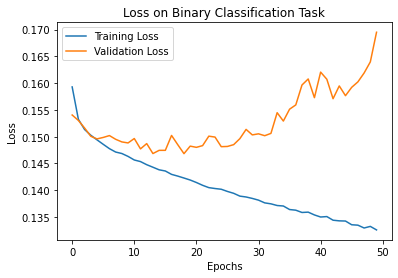

In [39]:
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Loss on Binary Classification Task')
plt.ylabel('Loss')
plt.xlabel('Epochs');

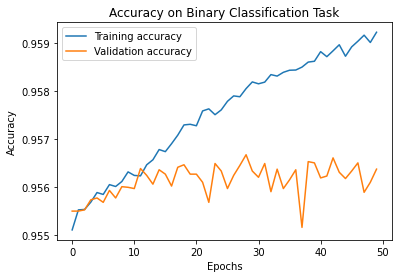

In [40]:
plt.plot(hist.history['accuracy'], label = 'Training accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Validation accuracy')
plt.legend()
plt.title('Accuracy on Binary Classification Task')
plt.ylabel('Accuracy')
plt.xlabel('Epochs');

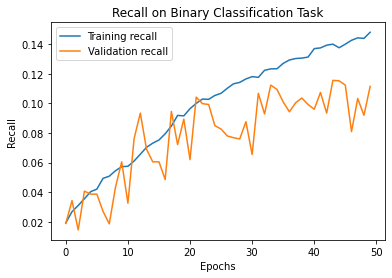

In [42]:
plt.plot(hist.history['recall'], label = 'Training recall')
plt.plot(hist.history['val_recall'], label = 'Validation recall')
plt.legend()
plt.title('Recall on Binary Classification Task')
plt.ylabel('Recall')
plt.xlabel('Epochs');

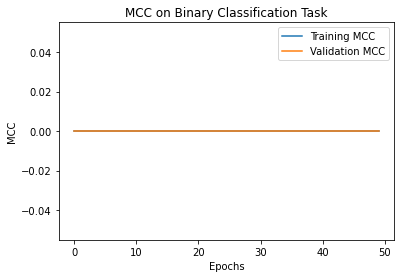

In [43]:
plt.plot(hist.history['MatthewsCorrelationCoefficient'], label = 'Training MCC')
plt.plot(hist.history['val_MatthewsCorrelationCoefficient'], label = 'Validation MCC')
plt.legend()
plt.title('MCC on Binary Classification Task')
plt.ylabel('MCC')
plt.xlabel('Epochs');

In [44]:
model.evaluate(X_test_sc, y_test)

2398/2398 [==============================] - 6s 3ms/step - loss: 0.1695 - accuracy: 0.9564 - recall: 0.1115 - MatthewsCorrelationCoefficient: 0.0000e+00


[0.1694907546043396, 0.9563721418380737, 0.11146682500839233, 0.0]

The model is not better than baseline!  Structural information is needed.

In [45]:
# save model
model.save(f'{get_home_path()}/models/no_structure/NS.h5')

In [64]:
logdir=get_home_path() + "/models/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [71]:
logdir

'/content/drive/MyDrive/GA/Capstone/ka_capstone/models/logs/fit/20220511-164446'

In [72]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [73]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  
# save results of fitting to a file

In [74]:

history = model.fit(
    X_train_sc, 
    y_train, 
    validation_data = (X_test_sc, y_test),
    batch_size=64, 
    epochs=5, 
    callbacks=[tb_callback]
)

Epoch 1/5
3597/3597 [==============================] - 12s 3ms/step - loss: 0.1277 - accuracy: 0.9600 - recall_3: 0.1663 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.1834 - val_accuracy: 0.9555 - val_recall_3: 0.1167 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/5
3597/3597 [==============================] - 13s 4ms/step - loss: 0.1275 - accuracy: 0.9600 - recall_3: 0.1665 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.1902 - val_accuracy: 0.9558 - val_recall_3: 0.1115 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/5
3597/3597 [==============================] - 13s 4ms/step - loss: 0.1272 - accuracy: 0.9600 - recall_3: 0.1698 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.1893 - val_accuracy: 0.9547 - val_recall_3: 0.1187 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 4/5
3597/3597 [==============================] - 13s 4ms/step - loss: 0.1271 - accuracy: 0.9602 - recall_3: 0.1705 - MatthewsCorrelationCoefficient: 0.000